In [ ]:
# Install required packages
!pip install yfinance
!pip install stable-baselines3[extra]
!pip install gymnasium
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install t

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

=== RL Stock Trading Bot Training ===

Downloaded 502 days of data
Technical indicators added successfully
Checking environment compatibility...
Environment check passed!

Starting model training...

Training DQN model...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 461      |
|    ep_rew_mean      | -82.6    |
|    exploration_rate | 0.805    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 415      |
|    time_elapsed     | 4        |
|    total_timesteps  | 1844     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 2.49e+04 |
|    n_updates        | 210      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 461      |
|    ep_rew_mean      | -63.8    |
|    exploration_ra

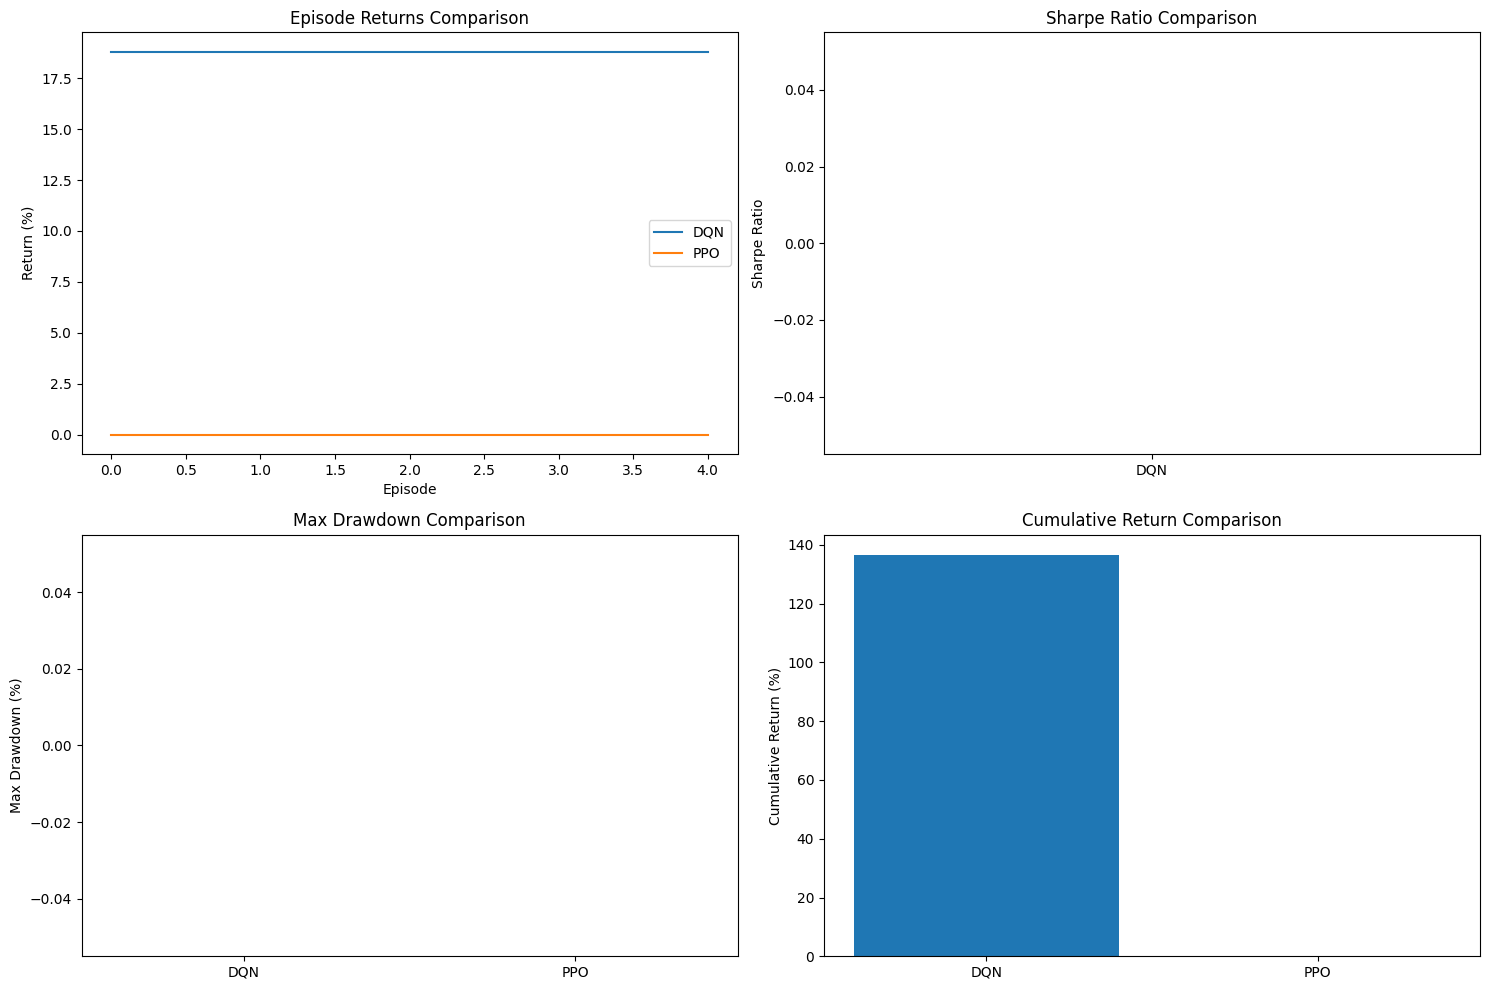

In [ ]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
import ta

class TradingEnvironment(gym.Env):
    """
    Custom Trading Environment for Reinforcement Learning
    Compatible with OpenAI Gym standards
    """

    def __init__(self, df, initial_balance=10000, transaction_cost=0.001,
                 stop_loss=0.05, take_profit=0.10, max_position_size=0.5):
        super(TradingEnvironment, self).__init__()

        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self.max_position_size = max_position_size

        # Action space: 0=Hold, 1=Buy, 2=Sell
        self.action_space = spaces.Discrete(3)

        # Observation space: OHLCV + technical indicators + portfolio state
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(20,), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None):
        """Reset the environment to initial state"""
        super().reset(seed=seed)

        self.current_step = 40  # Start after technical indicators are calculated
        self.balance = self.initial_balance
        self.shares_held = 0
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.trades = []
        self.buy_price = 0

        return self._get_observation(), {}

    def _get_observation(self):
        """Get current observation state"""
        if self.current_step >= len(self.df):
            self.current_step = len(self.df) - 1

        row = self.df.iloc[self.current_step]

        # Price features (normalized)
        price_features = [
            row['Open'] / row['Close'],
            row['High'] / row['Close'],
            row['Low'] / row['Close'],
            self.df['Volume'].rolling(20).mean().iloc[self.current_step] if self.df['Volume'].rolling(20).mean().iloc[self.current_step] > 0 else 1,
        ]

        # Technical indicators
        tech_indicators = [
            row['RSI'] / 100,
            row['MACD'] / row['Close'],
            row['MACD_Signal'] / row['Close'],
            row['BB_Upper'] / row['Close'],
            row['BB_Lower'] / row['Close'],
            row['SMA_20'] / row['Close'],
            row['EMA_12'] / row['Close'],
            row['ATR'] / row['Close'],
        ]

        # Portfolio state
        portfolio_state = [
            self.balance / self.initial_balance,
            self.shares_held / 1000,  # Normalized
            self.net_worth / self.initial_balance,
            (self.net_worth - self.max_net_worth) / self.initial_balance,  # Drawdown
        ]

        # Recent returns
        returns = [
            (row['Close'] - self.df.iloc[max(0, self.current_step-1)]['Close']) / self.df.iloc[max(0, self.current_step-1)]['Close'],
            (row['Close'] - self.df.iloc[max(0, self.current_step-5)]['Close']) / self.df.iloc[max(0, self.current_step-5)]['Close'],
            (row['Close'] - self.df.iloc[max(0, self.current_step-10)]['Close']) / self.df.iloc[max(0, self.current_step-10)]['Close'],
            (row['Close'] - self.df.iloc[max(0, self.current_step-20)]['Close']) / self.df.iloc[max(0, self.current_step-20)]['Close'],
        ]

        observation = np.array(price_features + tech_indicators + portfolio_state + returns, dtype=np.float32)
        return observation

    def step(self, action):
        """Execute one step in the environment"""
        current_price = self.df.iloc[self.current_step]['Close']
        reward = 0

        # Execute action
        if action == 1:  # Buy
            self._buy(current_price)
        elif action == 2:  # Sell
            self._sell(current_price)
        # action == 0 is Hold (do nothing)

        # Calculate current net worth
        self.net_worth = self.balance + self.shares_held * current_price

        # Risk management
        if self.shares_held > 0 and self.buy_price > 0:
            current_return = (current_price - self.buy_price) / self.buy_price

            # Stop loss
            if current_return <= -self.stop_loss:
                self._sell(current_price)
                reward -= 10  # Penalty for stop loss

            # Take profit
            elif current_return >= self.take_profit:
                self._sell(current_price)
                reward += 5  # Bonus for take profit

        # Calculate reward
        reward += self._calculate_reward()

        # Update max net worth
        if self.net_worth > self.max_net_worth:
            self.max_net_worth = self.net_worth

        # Move to next step
        self.current_step += 1

        # Check if episode is done
        done = self.current_step >= len(self.df) - 1
        truncated = False

        return self._get_observation(), reward, done, truncated, {}

    def _buy(self, price):
        """Execute buy action"""
        max_shares = int((self.balance * self.max_position_size) // price)
        if max_shares > 0 and self.balance > price * (1 + self.transaction_cost):
            shares_to_buy = max_shares
            total_cost = shares_to_buy * price * (1 + self.transaction_cost)

            if total_cost <= self.balance:
                self.balance -= total_cost
                self.shares_held += shares_to_buy
                self.buy_price = price

                self.trades.append({
                    'step': self.current_step,
                    'action': 'buy',
                    'price': price,
                    'shares': shares_to_buy,
                    'total': total_cost
                })

    def _sell(self, price):
        """Execute sell action"""
        if self.shares_held > 0:
            total_sale = self.shares_held * price * (1 - self.transaction_cost)
            self.balance += total_sale

            self.trades.append({
                'step': self.current_step,
                'action': 'sell',
                'price': price,
                'shares': self.shares_held,
                'total': total_sale
            })

            self.shares_held = 0
            self.buy_price = 0

    def _calculate_reward(self):
        """Calculate reward based on portfolio performance"""
        # Portfolio return
        portfolio_return = (self.net_worth - self.initial_balance) / self.initial_balance

        # Risk-adjusted return (simple Sharpe-like metric)
        if len(self.trades) > 1:
            returns = []
            for i in range(1, len(self.trades)):
                if self.trades[i]['action'] == 'sell' and self.trades[i-1]['action'] == 'buy':
                    trade_return = (self.trades[i]['price'] - self.trades[i-1]['price']) / self.trades[i-1]['price']
                    returns.append(trade_return)

            if returns:
                mean_return = np.mean(returns)
                std_return = np.std(returns) if len(returns) > 1 else 0.01
                sharpe_like = mean_return / std_return if std_return > 0 else 0
                return portfolio_return * 100 + sharpe_like * 10

        return portfolio_return * 100

def prepare_data(symbol='AAPL', period='2y'):
    """Download and prepare stock data with technical indicators"""
    print(f"Downloading data for {symbol}...")

    # Download data
    stock = yf.Ticker(symbol)
    df = stock.history(period=period)

    if df.empty:
        raise ValueError(f"No data found for symbol {symbol}")

    print(f"Downloaded {len(df)} days of data")

    # Add technical indicators
    df['RSI'] = ta.momentum.RSIIndicator(df['Close']).rsi()

    # MACD
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()

    # Moving Averages
    df['SMA_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
    df['EMA_12'] = ta.trend.EMAIndicator(df['Close'], window=12).ema_indicator()

    # ATR
    df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()

    # Fill NaN values
    df = df.fillna(method='bfill').fillna(method='ffill')

    print("Technical indicators added successfully")
    return df

class TradingCallback(BaseCallback):
    """Callback for monitoring training progress"""

    def __init__(self, verbose=0):
        super(TradingCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        return True

    def _on_rollout_end(self) -> None:
        if len(self.locals.get('episode_rewards', [])) > 0:
            self.episode_rewards.extend(self.locals['episode_rewards'])
            self.episode_lengths.extend(self.locals['episode_lengths'])

def train_dqn_model(env, total_timesteps=50000):
    """Train DQN model"""
    print("Training DQN model...")

    model = DQN(
        'MlpPolicy',
        env,
        learning_rate=0.0005,
        buffer_size=10000,
        learning_starts=1000,
        batch_size=32,
        tau=1.0,
        gamma=0.99,
        train_freq=4,
        gradient_steps=1,
        target_update_interval=1000,
        exploration_fraction=0.3,
        exploration_initial_eps=1.0,
        exploration_final_eps=0.05,
        verbose=1
    )

    callback = TradingCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    return model

def train_ppo_model(env, total_timesteps=50000):
    """Train PPO model"""
    print("Training PPO model...")

    model = PPO(
        'MlpPolicy',
        env,
        learning_rate=0.0003,
        n_steps=2048,
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        verbose=1
    )

    callback = TradingCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)

    return model

def evaluate_model(model, env, num_episodes=5):
    """Evaluate trained model"""
    print(f"Evaluating model over {num_episodes} episodes...")

    episode_rewards = []
    episode_returns = []
    all_trades = []

    for episode in range(num_episodes):
        obs, _ = env.reset()
        episode_reward = 0
        initial_balance = env.initial_balance

        while True:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, _ = env.step(action)
            episode_reward += reward

            if done or truncated:
                break

        final_return = (env.net_worth - initial_balance) / initial_balance * 100
        episode_rewards.append(episode_reward)
        episode_returns.append(final_return)
        all_trades.extend(env.trades)

        print(f"Episode {episode + 1}: Return = {final_return:.2f}%, Reward = {episode_reward:.2f}")

    avg_return = np.mean(episode_returns)
    avg_reward = np.mean(episode_rewards)

    print(f"\nAverage Return: {avg_return:.2f}%")
    print(f"Average Reward: {avg_reward:.2f}")
    print(f"Total Trades: {len(all_trades)}")

    return {
        'avg_return': avg_return,
        'avg_reward': avg_reward,
        'episode_returns': episode_returns,
        'trades': all_trades
    }

def calculate_metrics(returns, initial_balance=10000):
    """Calculate trading performance metrics"""
    if not returns:
        return {}

    returns_array = np.array(returns) / 100  # Convert percentage to decimal

    # Cumulative return
    cumulative_return = (1 + returns_array).prod() - 1

    # Sharpe ratio (assuming daily returns)
    if len(returns_array) > 1:
        sharpe_ratio = np.mean(returns_array) / np.std(returns_array) * np.sqrt(252)
    else:
        sharpe_ratio = 0

    # Maximum drawdown
    cumulative_returns = (1 + returns_array).cumprod()
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown = np.min(drawdowns)

    return {
        'cumulative_return': cumulative_return * 100,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown * 100,
        'total_trades': len(returns)
    }

# Main training script
def main():
    """Main function to run the complete training pipeline"""
    print("=== RL Stock Trading Bot Training ===\n")

    # Prepare data
    symbol = 'AAPL'  # You can change this to any stock symbol
    df = prepare_data(symbol, period='2y')

    # Create environment
    env = TradingEnvironment(df)

    # Verify environment
    print("Checking environment compatibility...")
    check_env(env)
    print("Environment check passed!\n")

    # Train models
    print("Starting model training...\n")

    # Train DQN
    dqn_model = train_dqn_model(env, total_timesteps=30000)
    dqn_results = evaluate_model(dqn_model, env)
    dqn_metrics = calculate_metrics(dqn_results['episode_returns'])

    print(f"\nDQN Results:")
    print(f"Cumulative Return: {dqn_metrics.get('cumulative_return', 0):.2f}%")
    print(f"Sharpe Ratio: {dqn_metrics.get('sharpe_ratio', 0):.2f}")
    print(f"Max Drawdown: {dqn_metrics.get('max_drawdown', 0):.2f}%")

    # Train PPO
    env.reset()  # Reset environment for PPO training
    ppo_model = train_ppo_model(env, total_timesteps=30000)
    ppo_results = evaluate_model(ppo_model, env)
    ppo_metrics = calculate_metrics(ppo_results['episode_returns'])

    print(f"\nPPO Results:")
    print(f"Cumulative Return: {ppo_metrics.get('cumulative_return', 0):.2f}%")
    print(f"Sharpe Ratio: {ppo_metrics.get('sharpe_ratio', 0):.2f}")
    print(f"Max Drawdown: {ppo_metrics.get('max_drawdown', 0):.2f}%")

    # Save models
    print("\nSaving models...")
    dqn_model.save("dqn_trading_model")
    ppo_model.save("ppo_trading_model")

    # Save test data for Streamlit app
    test_df = df.tail(100).copy()  # Last 100 days for testing
    test_df.to_csv('test_data.csv')

    print("Models and test data saved successfully!")
    print("\nDownload the following files to use with the Streamlit app:")
    print("- dqn_trading_model.zip")
    print("- ppo_trading_model.zip")
    print("- test_data.csv")

    # Plot training results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(dqn_results['episode_returns'], label='DQN')
    plt.plot(ppo_results['episode_returns'], label='PPO')
    plt.title('Episode Returns Comparison')
    plt.xlabel('Episode')
    plt.ylabel('Return (%)')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.bar(['DQN', 'PPO'], [dqn_metrics.get('sharpe_ratio', 0), ppo_metrics.get('sharpe_ratio', 0)])
    plt.title('Sharpe Ratio Comparison')
    plt.ylabel('Sharpe Ratio')

    plt.subplot(2, 2, 3)
    plt.bar(['DQN', 'PPO'], [dqn_metrics.get('max_drawdown', 0), ppo_metrics.get('max_drawdown', 0)])
    plt.title('Max Drawdown Comparison')
    plt.ylabel('Max Drawdown (%)')

    plt.subplot(2, 2, 4)
    plt.bar(['DQN', 'PPO'], [dqn_metrics.get('cumulative_return', 0), ppo_metrics.get('cumulative_return', 0)])
    plt.title('Cumulative Return Comparison')
    plt.ylabel('Cumulative Return (%)')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

**Reasoning**:
Run the Streamlit application in the background and then use ngrok to expose the default Streamlit port (8501).



## Authenticate ngrok

### Subtask:
Authenticate ngrok using the provided authentication token.

In [ ]:
import subprocess
import threading
import time
from pyngrok import ngrok

# Kill any running ngrok processes
!kill $(ps aux | grep 'ngrok' | grep -v 'grep' | awk '{print $2}') 2>/dev/null || true
!kill $(ps aux | grep 'streamlit' | grep -v 'grep' | awk '{print $2}') 2>/dev/null || true

# Set up ngrok tunnel
authtoken = "djiwepoc" # Replace with your ngrok authtoken if you haven't set it globally
ngrok.set_auth_token(authtoken)

# Start Streamlit
# Running without shell=True to potentially see Streamlit's output directly
process = subprocess.Popen(["streamlit", "run", "streamlit_app.py"])

# Give Streamlit a moment to start
time.sleep(10)

# Open a tunnel to the Streamlit port (default is 8501)
public_url = ngrok.connect(addr=8501)

print(f"Streamlit app running at: {public_url}")

# Keep the Colab cell alive
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("Shutting down...")
    process.terminate()
    ngrok.disconnect(public_url)
    print("Shutdown complete.")

Streamlit app running at: NgrokTunnel: "https://e21d-34-169-154-77.ngrok-free.app" -> "http://localhost:8501"
